In [10]:
# 载入必要的库
import numpy as np
import tensorflow as tf
import keras

from matplotlib import pyplot as plt

from keras import Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D,AveragePooling2D
from keras.layers import Flatten, Dropout, Dense, Input, Concatenate, add, Activation
from tensorflow.keras.applications import VGG16

## 读取数据 

###  构建数据生成器

In [2]:
IMSIZE=128

train_generator = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.5,
    rotation_range=30,
    zoom_range=0.2, 
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True).flow_from_directory(
    '/course7/data/data_des/train',
    target_size=(IMSIZE, IMSIZE),
    batch_size=100,
    class_mode='categorical')

validation_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    '/course7/data/data_des/train',
    target_size=(IMSIZE, IMSIZE),
    batch_size=100,
    class_mode='categorical')


Found 15304 images belonging to 2 classes.
Found 15304 images belonging to 2 classes.


###  可视化

<Figure size 432x288 with 0 Axes>

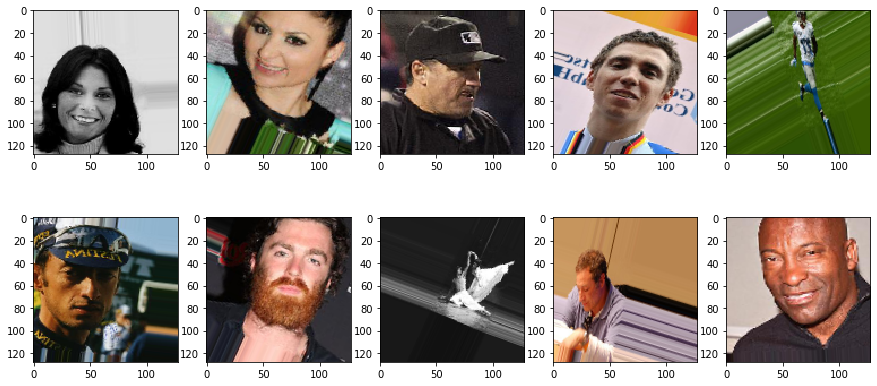

In [3]:
plt.figure()
fig,ax = plt.subplots(2,5)
fig.set_figheight(7)
fig.set_figwidth(15)
ax=ax.flatten()
X,Y=next(train_generator)
for i in range(10): ax[i].imshow(X[i,:,:,:])

### 构建DenseNet模型 

### 模型建立 

In [11]:
IMSIZE=128

# 每个dense block中dense layer数目 
nb_layers = 3
# 增长率
growth_rate = 32  

# 输入层
input_layer = Input([IMSIZE,IMSIZE,3])
x = input_layer

# 初始卷积层
x = BatchNormalization()(x)
x = Conv2D(growth_rate*2, (3,3), padding='same', activation='relu')(x)


# 设置 [Dense Block + Transition Block] 多个，此处以1个为例
for j in range(3):
    # 1.Dense Block
    # 用一个列表存放提供特征的层
    feature_list = [x]
    for i in range(nb_layers):   
        x = BatchNormalization()(x)
        x = Conv2D(growth_rate, (3, 3), padding="same", activation='relu')(x)   
        feature_list.append(x)
        if i<(nb_layers-1):
            x = Concatenate()(feature_list)
        
    
    # 2.Transition Block
    x = BatchNormalization()(x)
    x = Conv2D(growth_rate, (1, 1), padding="same", activation='relu')(x)
    x = AveragePooling2D((2, 2), strides=(2, 2))(x)
    

    
feature_list = [x]
for i in range(nb_layers):            
    x = Conv2D(growth_rate, (3, 3), padding="same", activation='relu')(x)   
    feature_list.append(x)
    if i<(nb_layers-1):
        x = Concatenate()(feature_list)

# 全局池化
x = GlobalAveragePooling2D()(x)
x = Dense(2,activation='softmax')(x)
output_layer = x
model = Model(input_layer,output_layer)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
batch_normalization_13 (BatchNo (None, 128, 128, 3)  12          input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 128, 128, 64) 1792        batch_normalization_13[0][0]     
__________________________________________________________________________________________________
batch_normalization_14 (BatchNo (None, 128, 128, 64) 256         conv2d_13[0][0]                  
____________________________________________________________________________________________

### 模型编译及拟合 

In [12]:
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.0001),metrics=['accuracy'])
model.fit(train_generator,epochs=5,validation_data=validation_generator)

Epoch 1/5
154/154 [==============================] - 225s 1s/step - loss: 0.5240 - accuracy: 0.7697 - val_loss: 0.3279 - val_accuracy: 0.7718
Epoch 2/5
154/154 [==============================] - 182s 1s/step - loss: 0.4879 - accuracy: 0.7843 - val_loss: 0.7085 - val_accuracy: 0.7495
Epoch 3/5
154/154 [==============================] - 248s 2s/step - loss: 0.4670 - accuracy: 0.7974 - val_loss: 0.3437 - val_accuracy: 0.7744
Epoch 4/5
154/154 [==============================] - 211s 1s/step - loss: 0.4515 - accuracy: 0.8064 - val_loss: 0.5981 - val_accuracy: 0.8151
Epoch 5/5
154/154 [==============================] - 177s 1s/step - loss: 0.4417 - accuracy: 0.8100 - val_loss: 0.2268 - val_accuracy: 0.8285
